#Data preparation

In [ ]:
# import main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

In [ ]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
# Principal Component Analysis
from sklearn.decomposition import PCA

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import dataframe (without outliers)
df = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/df_prep_no_outliers.xlsx", index_col="Unnamed: 0")

In [ ]:
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
df.drop(df[to_drop].columns, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
# get the median for each emotion
df["loudness"] = df.groupby("emotion")["intensity"].transform("median")
# categorize records as "louder" or "non louder", basing on the median for each emotion
df["loudness"] = df.apply(lambda x: "high" if x["intensity"] > x["loudness"] else "low", axis=1)

In [ ]:
# get loudness labels
y_loudness = df["loudness"]
df["emotion_type"] = df.apply(lambda x: "strong" if x["emotion"] in ("fearful","angry","happy","surprised", "disgust") else "weak", axis=1)

# define two groups of emphasis level
# high emphasis
df_emph_high = df[
    # strong emotions with high loudness
    ((df["loudness"] == "high") & (df["emotion"].isin(("fearful","angry","happy","surprised","disgust")))) | 
    # weak emotions with low loudness
    ((df["loudness"] == "low") & (df["emotion"].isin(("sad","neutral","calm"))))
    ]
# low emphasis
df_emph_low = df[
    # strong emotions with low loudness
    ((df["loudness"] == "low") & (df["emotion"].isin(("fearful","angry","happy","surprised","disgust")))) | 
    # weak emotions with high loudness
    ((df["loudness"] == "high") & (df["emotion"].isin(("sad","neutral","calm"))))
    ]

# get data columns
df_data = df.loc[:, "length_ms":"skew"]
df_data_emph_high = df_emph_high.loc[:, "length_ms":"skew"]
df_data_emph_low = df_emph_low.loc[:, "length_ms":"skew"]

# get values from data columns
X = df_data.values
X_emph_high = df_data_emph_high.values
X_emph_low = df_data_emph_low.values

# get emotion lables from each emphasis group
y_emotion_emph_high = df_emph_high["emotion"]
y_emotion_emph_low = df_emph_low["emotion"]

# get emotion type from each emphasis group
y_emtype_emph_high = df_emph_high["emotion_type"]
y_emtype_emph_low = df_emph_low["emotion_type"]

### Normalizations

In [ ]:
# get StandardScaler
std_scaler = StandardScaler()

# normalise each emphasis group with StandardScaler
X_std = std_scaler.fit_transform(X)
X_std_emph_high = std_scaler.fit_transform(X_emph_high)
X_std_emph_low = std_scaler.fit_transform(X_emph_low)

# get MinMaxScaler
mima_scaler = MinMaxScaler()

# normalise each emphasis group with MinMaxScaler
X_mima = mima_scaler.fit_transform(X)
X_mima_emph_high = mima_scaler.fit_transform(X_emph_high)
X_mima_emph_low = mima_scaler.fit_transform(X_emph_low)

##PCA

#KMeans

### High emphasis

In [ ]:
# get KMeans
kmeans = KMeans(n_clusters=4, n_init=100, max_iter=3000, random_state=1)
# fit KMeans
kmeans.fit(X_std_emph_high)

KMeans(max_iter=3000, n_clusters=4, n_init=100, random_state=1)

In [ ]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score
for k in range(2, 16):
  # get KMeans
  kmeans = KMeans(n_clusters=k, n_init=100, max_iter=3000, random_state=1)
  # fit KMeans
  kmeans.fit(X_std_emph_high)
  #print('Silhouette', silhouette_score(X_std_emph_high, kmeans.labels_))
  print(adjusted_rand_score(y_emotion_emph_high, kmeans.labels_))

0.11764505631204307


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


0.1009170835979971


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'KMeans clustering')

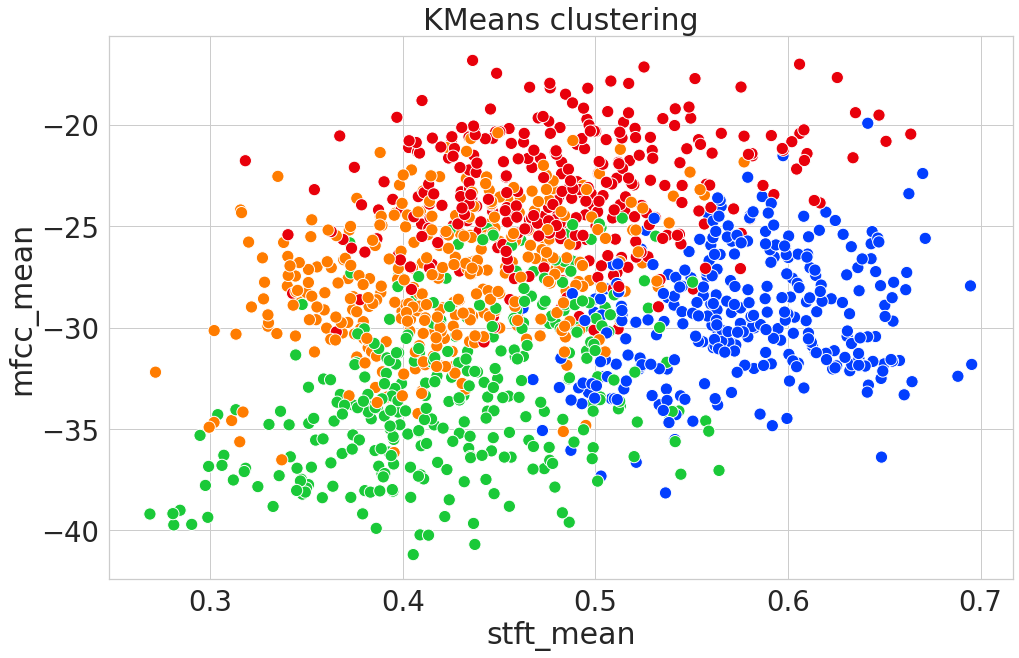

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df_emph_high, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
# Set title with matplotlib
plt.title('KMeans clustering')

In [ ]:
centers = kmeans.cluster_centers_
std_scaler.fit(X_emph_high)
centers = std_scaler.inverse_transform(centers)

In [ ]:
df_data_emph_high['kmeans_labels'] = kmeans.labels_

In [ ]:
df_data_emph_high.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1318 entries, 2 to 2447
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   length_ms           1318 non-null   int64  
 1   intensity           1318 non-null   float64
 2   zero_crossings_sum  1318 non-null   float64
 3   mfcc_mean           1318 non-null   float64
 4   mfcc_max            1318 non-null   float64
 5   sc_mean             1318 non-null   float64
 6   sc_std              1318 non-null   float64
 7   sc_min              1318 non-null   float64
 8   sc_max              1318 non-null   float64
 9   sc_kur              1318 non-null   float64
 10  stft_mean           1318 non-null   float64
 11  stft_std            1318 non-null   float64
 12  stft_min            1318 non-null   float64
 13  stft_kur            1318 non-null   float64
 14  mean                1318 non-null   float64
 15  kur                 1318 non-null   float64
 16  skew  

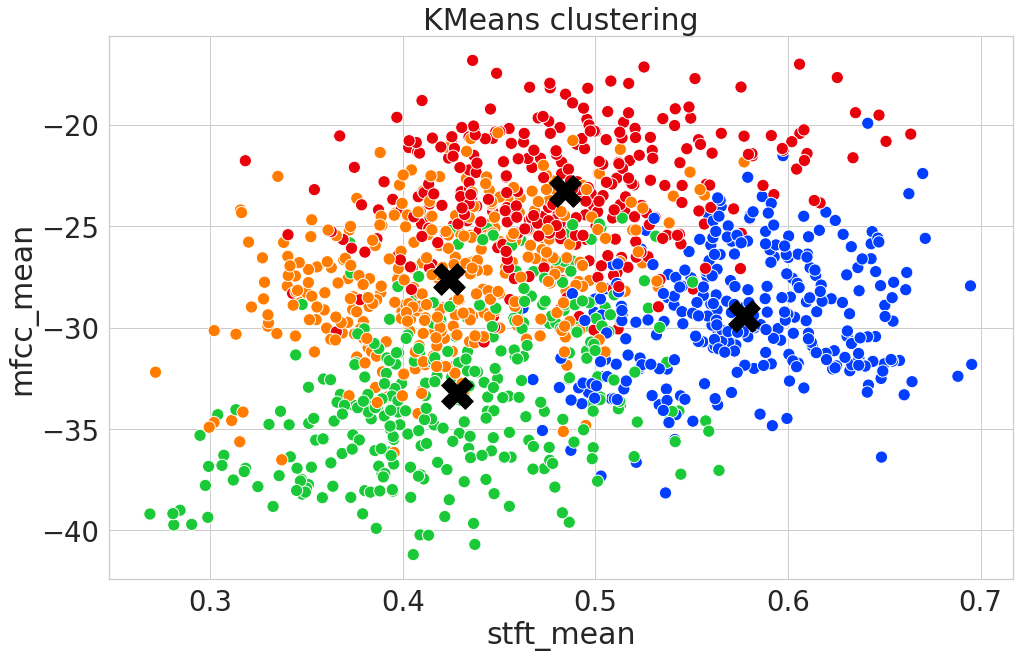

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df_emph_high, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
 
# Set title with matplotlib
plt.title('KMeans clustering')
plt.scatter(centers[:,10], centers[:,3], c='black', marker='X', s=1000)
plt.show()

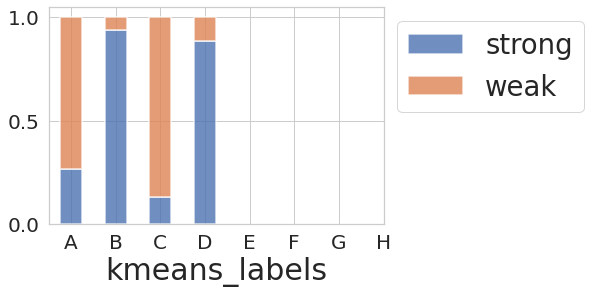

In [ ]:
bar_pl = y_emtype_emph_high.groupby(df_data_emph_high['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

In [ ]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([307, 367, 322, 322]))

In [ ]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X_std_emph_high, kmeans.labels_))

SSE 15070.947929657581
Silhouette 0.1363120478832607


### Low emphasis

In [ ]:
# get KMeans
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=3000, random_state=1)
# fit KMeans
kmeans.fit(X_std_emph_low)

KMeans(max_iter=3000, n_clusters=3, n_init=100, random_state=1)

In [ ]:
for k in range(2, 31):
  # get KMeans
  kmeans = KMeans(n_clusters=k, n_init=100, max_iter=3000, random_state=1)
  # fit KMeans
  kmeans.fit(X_std_emph_low)
  print('Silhouette', silhouette_score(X_std_emph_low, kmeans.labels_))

Silhouette 0.1583980593178405
Silhouette 0.15720922375532181
Silhouette 0.15158890898806882
Silhouette 0.13154247293858856
Silhouette 0.13039805637007698
Silhouette 0.11808089933681246
Silhouette 0.11535857204676181
Silhouette 0.11825581854914018


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


Silhouette 0.11290305675769811
Silhouette 0.11470153740636749


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'KMeans clustering')

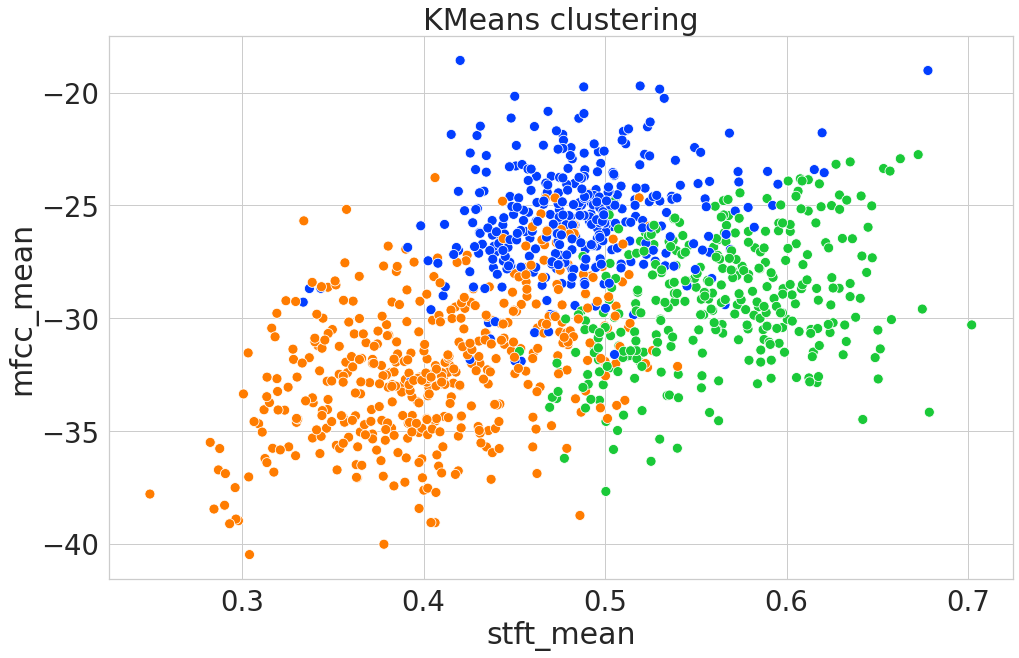

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
 
# Create plot
sns.scatterplot(
    data=df_emph_low, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=100,
    legend=False
)
 
# Set title with matplotlib
plt.title('KMeans clustering')

In [ ]:
centers = kmeans.cluster_centers_
std_scaler.fit(X_emph_low)
centers = std_scaler.inverse_transform(centers)

In [ ]:
df_data_emph_low['kmeans_labels'] = kmeans.labels_

In [ ]:
df_data_emph_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1134 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   length_ms           1134 non-null   int64  
 1   intensity           1134 non-null   float64
 2   zero_crossings_sum  1134 non-null   float64
 3   mfcc_mean           1134 non-null   float64
 4   mfcc_max            1134 non-null   float64
 5   sc_mean             1134 non-null   float64
 6   sc_std              1134 non-null   float64
 7   sc_min              1134 non-null   float64
 8   sc_max              1134 non-null   float64
 9   sc_kur              1134 non-null   float64
 10  stft_mean           1134 non-null   float64
 11  stft_std            1134 non-null   float64
 12  stft_min            1134 non-null   float64
 13  stft_kur            1134 non-null   float64
 14  mean                1134 non-null   float64
 15  kur                 1134 non-null   float64
 16  skew  

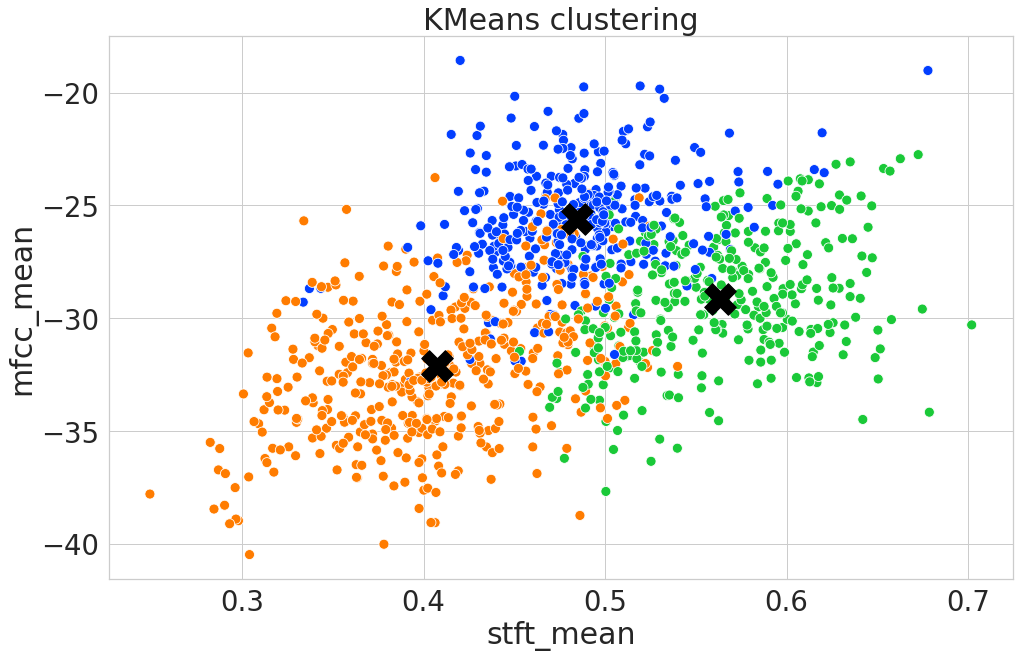

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
 
# Create plot
sns.scatterplot(
    data=df_emph_low, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=100,
    legend=False
)
 
# Set title with matplotlib
plt.title('KMeans clustering')
plt.scatter(centers[:,10], centers[:,3], c='black', marker='X', s=1000)
plt.show()

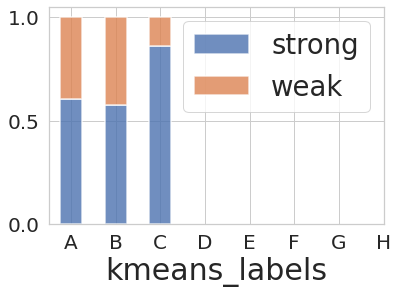

In [ ]:
bar_pl = y_emtype_emph_low.groupby(df_data_emph_low['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

In [ ]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([348, 457, 329]))

In [ ]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X_std_emph_low, kmeans.labels_))

SSE 14020.495067077929
Silhouette 0.15720922375532181


#DBSCAN

##High emphasis

In [ ]:
dbscan = DBSCAN(eps=0.37)
dbscan.fit(X_mima_emph_high)

DBSCAN(eps=0.37)

In [ ]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score
for k in [0.3, 0.35, 0.37, 0.4, 0.45, 0.5]:
  dbscan = DBSCAN(eps=k)
  dbscan.fit(X_mima_emph_high)  
  #print('Silhouette', silhouette_score(X_std_emph_high, kmeans.labels_))
  print(adjusted_rand_score(y_emotion_emph_high, dbscan.labels_))

0.0026505687791710227
0.013277800936645845
0.016418678391889464
0.013291970272638997
0.0035781842981649913
-0.0013422998184495166


Text(0.5, 1.0, 'DBSCAN clustering')

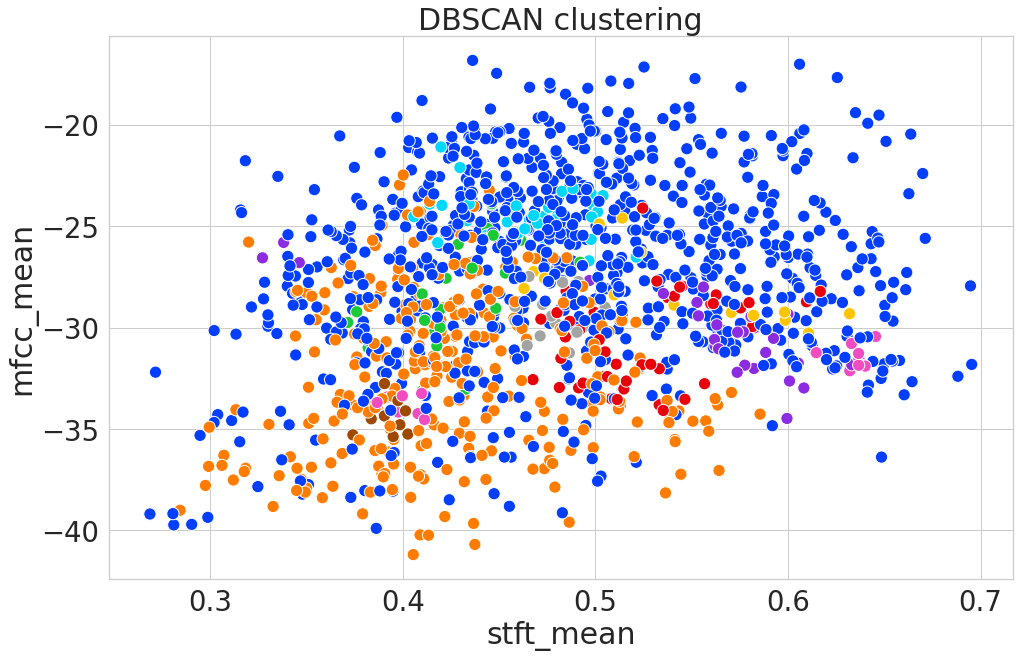

In [ ]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df_emph_high, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=dbscan.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
# Set title with matplotlib
plt.title('DBSCAN clustering')

In [ ]:
df_data_emph_high['dbscan_labels'] = dbscan.labels_
#df_data_emph_high['dbscan_labels'] = df_data_emph_high['dbscan_labels'].map({0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H"})

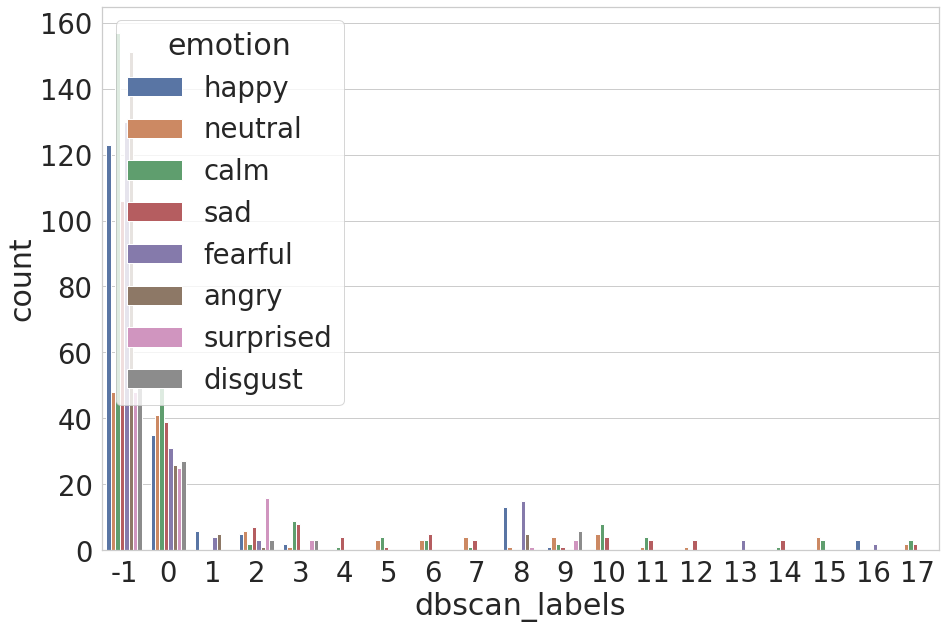

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df_data_emph_high, x='dbscan_labels', hue=y_emotion_emph_high)
plt.show()

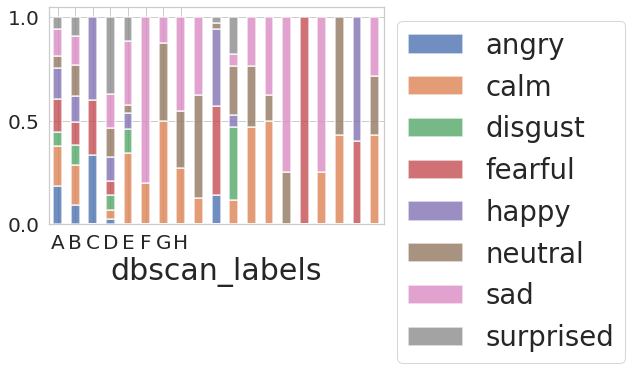

In [ ]:
bar_pl = y_emotion_emph_high.groupby(df_data_emph_high['dbscan_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

In [ ]:
#print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X_mima_emph_high, dbscan.labels_))

Silhouette -0.23990462582886213


### kth neighbor distance

In [ ]:
dist = pdist(X_std_emph_high, 'euclidean')
dist = squareform(dist)

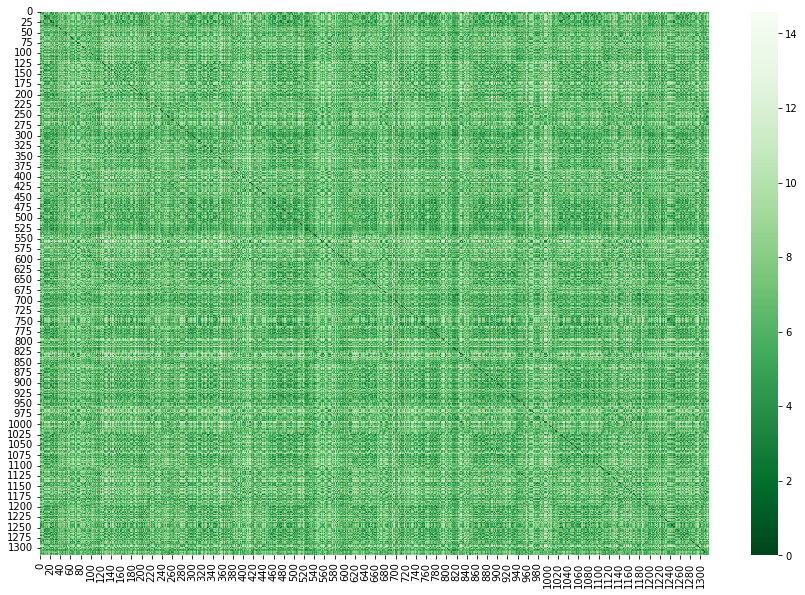

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(dist, cmap="Greens_r", annot=False)
plt.show()

In [ ]:
k=5
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

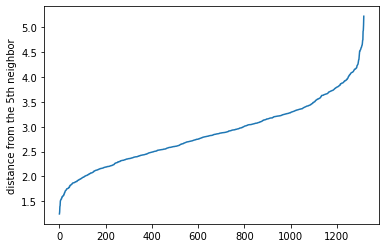

In [ ]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('distance from the {}th neighbor'.format(k))
         
plt.show()

##Low emphasis

### DBScan

In [ ]:
dbscan = DBSCAN()
dbscan.fit(X_mima_emph_high)

DBSCAN()

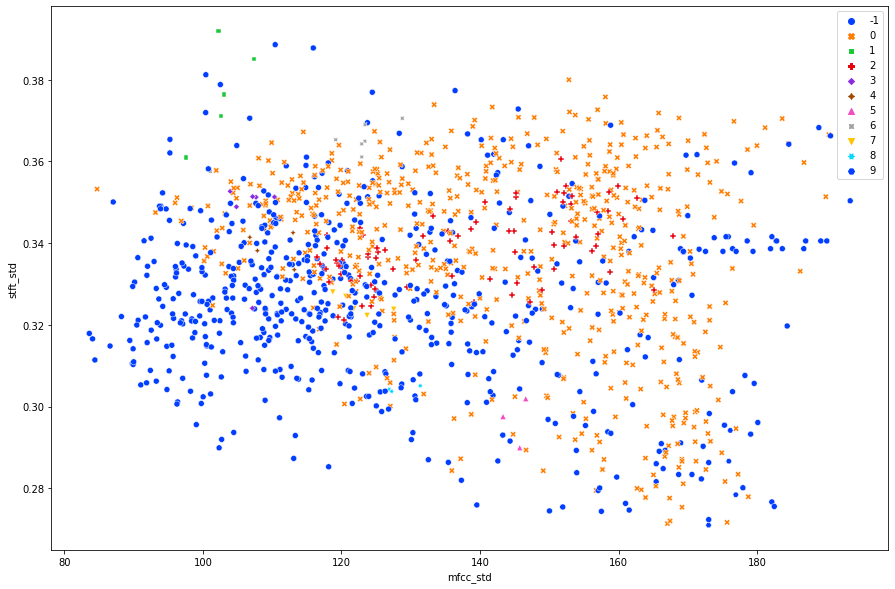

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df_emph_high, x="mfcc_std", y="stft_std", hue=dbscan.labels_, 
                style=dbscan.labels_, palette="bright")
plt.show()

### kth neighbor distance

In [ ]:
dist = pdist(X_std_emph_high, 'euclidean')
dist = squareform(dist)

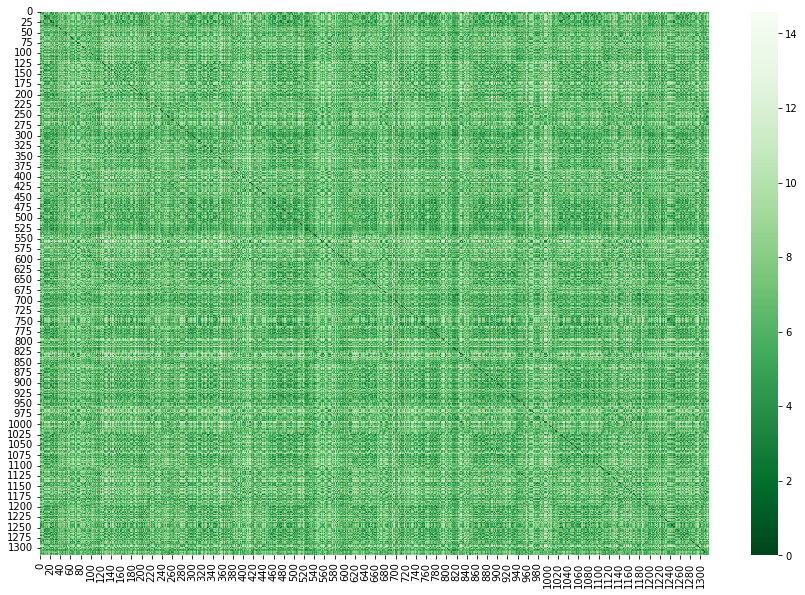

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(dist, cmap="Greens_r", annot=False)
plt.show()

In [ ]:
k=5
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

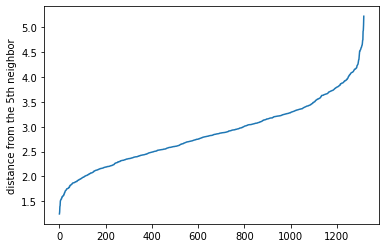

In [ ]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('distance from the {}th neighbor'.format(k))
         
plt.show()

#Agglomerative Clustering

## High emphasis

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=8)
model = model.fit(X_std_emph_high)

AttributeError: ignored

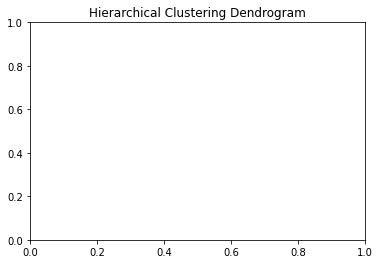

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
df_data_emph_high['hier_labels'] = model.labels_

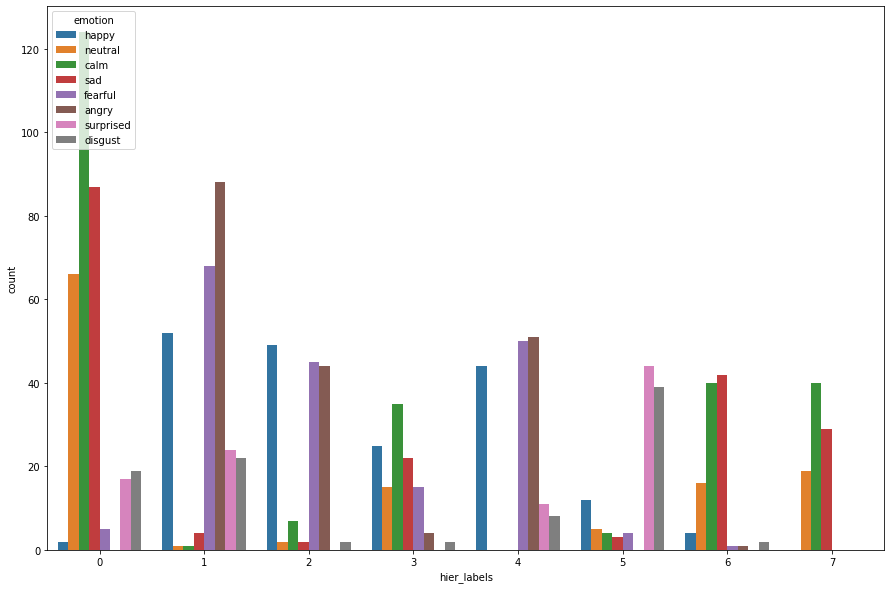

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df_data_emph_high, x='hier_labels', hue=y_emotion_emph_high)
plt.show()

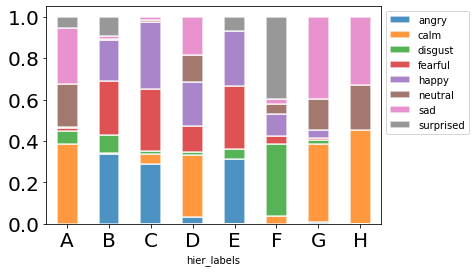

In [ ]:
bar_pl = y_emotion_emph_high.groupby(df_data_emph_high['hier_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

In [ ]:
#print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X_mima_emph_high, model.labels_))

Silhouette 0.08169228757029928


#### Choosing the number of clusters

In [ ]:
hier = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
hier.fit(X_std_emph_high)

AgglomerativeClustering(linkage='complete', n_clusters=5)

In [ ]:
hier.labels_

array([3, 3, 2, ..., 4, 4, 2])

#### Precomputed distance matrix

In [ ]:
hier = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='complete')
hier.fit(dist)

AgglomerativeClustering(affinity='precomputed', linkage='complete')

In [ ]:
sns.scatterplot(data=df, x="mfcc_std", y="mfcc_mean", hue=hier.labels_, 
                style=hier.labels_, palette="bright")
plt.show()

ValueError: ignored

## Low emphasis

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model = model.fit(X_std_emph_high)

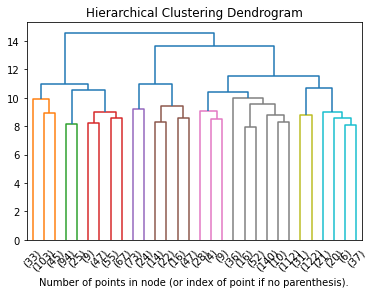

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

#### Choosing the number of clusters

In [ ]:
hier = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
hier.fit(X_std_emph_high)

AgglomerativeClustering(linkage='complete', n_clusters=5)

In [ ]:
hier.labels_

array([3, 3, 2, ..., 4, 4, 2])

#### Precomputed distance matrix

In [ ]:
hier = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='complete')
hier.fit(dist)

AgglomerativeClustering(affinity='precomputed', linkage='complete')

In [ ]:
sns.scatterplot(data=df, x="mfcc_std", y="mfcc_mean", hue=hier.labels_, 
                style=hier.labels_, palette="bright")
plt.show()

ValueError: ignored